In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv(r'C:\Users\Maintenant prêt\Desktop\STOCK\Data\tm_long_data.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,2.334144,2.296798,0.000000,41109
1,1980-03-18,2.306134,2.343480,2.306134,0.000000,9343
2,1980-03-19,2.306134,2.306134,2.306134,2.306134,0
3,1980-03-20,2.306134,2.343480,2.306134,0.000000,10277
4,1980-03-21,2.362153,2.399499,2.362153,0.000000,8409
...,...,...,...,...,...,...
11306,2025-01-23,186.270004,186.699997,185.050003,186.009995,237700
11307,2025-01-24,186.610001,187.460007,185.399994,185.979996,278900
11308,2025-01-27,186.500000,187.059998,185.820007,186.800003,308100
11309,2025-01-28,185.289993,186.399994,184.149994,186.149994,382600


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Close,High,Low,Open,Volume
Date,,,,,
1980-03-17,2.296798,2.334144,2.296798,0.000000,41109
1980-03-18,2.306134,2.343480,2.306134,0.000000,9343
1980-03-19,2.306134,2.306134,2.306134,2.306134,0
1980-03-20,2.306134,2.343480,2.306134,0.000000,10277
1980-03-21,2.362153,2.399499,2.362153,0.000000,8409
...,...,...,...,...,...
2025-01-23,186.270004,186.699997,185.050003,186.009995,237700
2025-01-24,186.610001,187.460007,185.399994,185.979996,278900
2025-01-27,186.500000,187.059998,185.820007,186.800003,308100


In [6]:
# check the frequency
print(data.index.freq)

None


In [7]:
# Set the frequency to daily
data = data.resample('D').ffill()

In [8]:
print(data.index.freq)

<Day>


In [9]:
# check for missing
data.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## Stationarity Check

In [10]:
# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -0.2829792596560708
p-value: 0.927880624059201
Critical Values:
   1%: -3.430750044469181
   5%: -2.861716803420753
   10%: -2.5668641080075107
The data is non-stationary (fail to reject the null hypothesis).


In [11]:
# Apply differencing
data['Close_diff'] = data['Close'].diff().dropna()

In [12]:
data

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
1980-03-17,2.296798,2.334144,2.296798,0.000000,41109,NaN
1980-03-18,2.306134,2.343480,2.306134,0.000000,9343,0.009336
1980-03-19,2.306134,2.306134,2.306134,2.306134,0,0.000000
1980-03-20,2.306134,2.343480,2.306134,0.000000,10277,0.000000
1980-03-21,2.362153,2.399499,2.362153,0.000000,8409,0.056019
...,...,...,...,...,...,...
2025-01-25,186.610001,187.460007,185.399994,185.979996,278900,0.000000
2025-01-26,186.610001,187.460007,185.399994,185.979996,278900,0.000000
2025-01-27,186.500000,187.059998,185.820007,186.800003,308100,-0.110001


In [13]:
# drop Na from close_diff
data.dropna(inplace=True)

In [14]:
# Use only the 'Close_diff' column
data = data[['Close_diff']]

In [15]:
data

,Close_diff
Date,
1980-03-18,0.009336
1980-03-19,0.000000
1980-03-20,0.000000
1980-03-21,0.056019
1980-03-22,0.000000
...,...
2025-01-25,0.000000
2025-01-26,0.000000
2025-01-27,-0.110001


## Train-Test split

In [16]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Models

## ARIMA

# Fit ARIMA Model:

In [17]:
model = ARIMA(train['Close_diff'], order=(1, 0, 1))
fitted_model = model.fit()

# Forecaast and Evaluate

In [18]:
# Generate forecasts using the fitted ARIMA model
arima_forecast = fitted_model.predict(start=test.index[0], end=test.index[-1])

mae_arima = mean_absolute_error(test['Close_diff'], arima_forecast)
# Calculate MSE first, then take the square root for RMSE
mse_arima = mean_squared_error(test['Close_diff'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE using NumPy
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')

ARIMA MAE: 1.0489528319916572, RMSE: 1.8199811835834288


# LSTM Model

## Preprocess Data for LSTM

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Close_diff']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)

## Build LSTM Model:

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train LSTM Model

In [21]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0165
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0017
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0016
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0016
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0016
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0016
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0017
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0016
Epoch 9/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0017
Epoch 10/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0017


## Forecast and Evaluate

In [22]:
scaled_test = scaler.transform(test[['Close_diff']])
X_test, y_test = create_sequences(scaled_test, seq_length)
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

#mae = mean_absolute_error(test['Close_diff'].iloc[seq_length:], predictions)
#print('LSTM MAE:', mae)

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [23]:
mae_lstm = mean_absolute_error(test[seq_length:], predictions)
rmse_lstm = np.sqrt(mean_squared_error(test[seq_length:], predictions))
print(f'LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}')

LSTM MAE: 1.1327520608901978, RMSE: 1.844822910876409


# Prophet Model

## Prepare Data for Prophet

In [24]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close': 'y'})

## Fit Prophet Model

In [25]:
from prophet import Prophet

train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close_diff': 'y'})

# Remove timezone information from the 'ds' column
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet = Prophet()
model_prophet.fit(train_prophet)

07:36:31 - cmdstanpy - INFO - Chain [1] start processing
07:36:33 - cmdstanpy - INFO - Chain [1] done processing


## Forecast and Evaluate:

In [26]:
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)
forecast = forecast.iloc[-len(test):]

#mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
#print('Prophet MAE:', mae)

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [27]:
# evaluate with MAE and RMSE
mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['Close_diff'], forecast['yhat']))
print('Prophet MAE:', mae)
print('Prophet RMSE:', rmse)

Prophet MAE: 1.0557420131131838
Prophet RMSE: 1.8197409620888234


# Compare Models

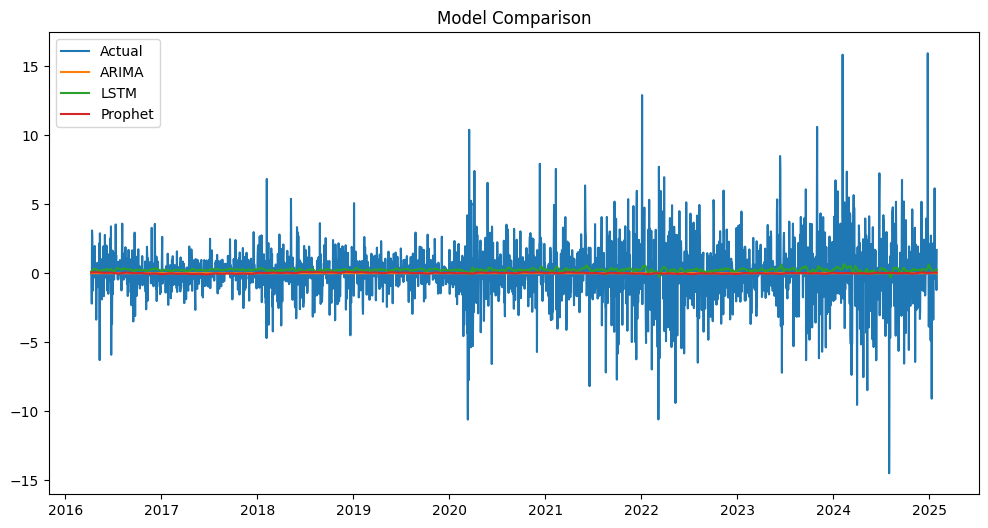

In [28]:
# Adjust the plotting to use the same range for all data
plt.figure(figsize=(12, 6))

# Slice test['Close'] to match the length of predictions for LSTM
plt.plot(test.index[seq_length:], test['Close_diff'].iloc[seq_length:], label='Actual')

plt.plot(test.index[seq_length:], arima_forecast[seq_length:], label='ARIMA')

plt.plot(test.index[seq_length:], predictions[:, 0], label='LSTM')  # Extract the first column of predictions

plt.plot(test.index[seq_length:], forecast['yhat'].iloc[seq_length:], label='Prophet')  # Slice forecast['yhat']

plt.legend()
plt.title('Model Comparison')
plt.show()

In [29]:
# compare the model in tabel form
models = ['ARIMA', 'LSTM', 'Prophet']
maes = [mae_arima, mae_lstm, mae]
rmses = [rmse_arima, rmse_lstm, rmse]


In [30]:
data = {'Model': models, 'MAE': maes, 'RMSE': rmses}
df_compare = pd.DataFrame(data)

print(df_compare)

     Model       MAE      RMSE
0    ARIMA  1.048953  1.819981
1     LSTM  1.132752  1.844823
2  Prophet  1.055742  1.819741
